In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications.imagenet_utils import preprocess_input,decode_predictions

In [3]:
covid_train = "/kaggle/input/new-dataset/new/data/Data/train/COVID19"
normal_train = "/kaggle/input/new-dataset/new/data/Data/train/NORMAL"
pneumonia_train = "/kaggle/input/new-dataset/new/data/Data/train/PNEUMONIA"
lung_opacity="/kaggle/input/new-dataset/new/data/Data/train/Lung_Opacity"

len_covid_train = len(os.listdir(covid_train))
len_normal_train = len(os.listdir(normal_train))
len_pneumonia_train =  len(os.listdir(pneumonia_train))
len_lung_opacity= len(os.listdir(lung_opacity))

print("Number of covid Images:",len_covid_train)
print("Number of normal Images:",len_normal_train)
print("Number of pneumonia Images:",len_pneumonia_train)
print("Number of lung_opacity Images:",len_lung_opacity)
print("Total Number of Images:",len_covid_train+len_normal_train+len_pneumonia_train+len_lung_opacity)

Number of covid Images: 1492
Number of normal Images: 1266
Number of pneumonia Images: 1500
Number of lung_opacity Images: 1380
Total Number of Images: 5638


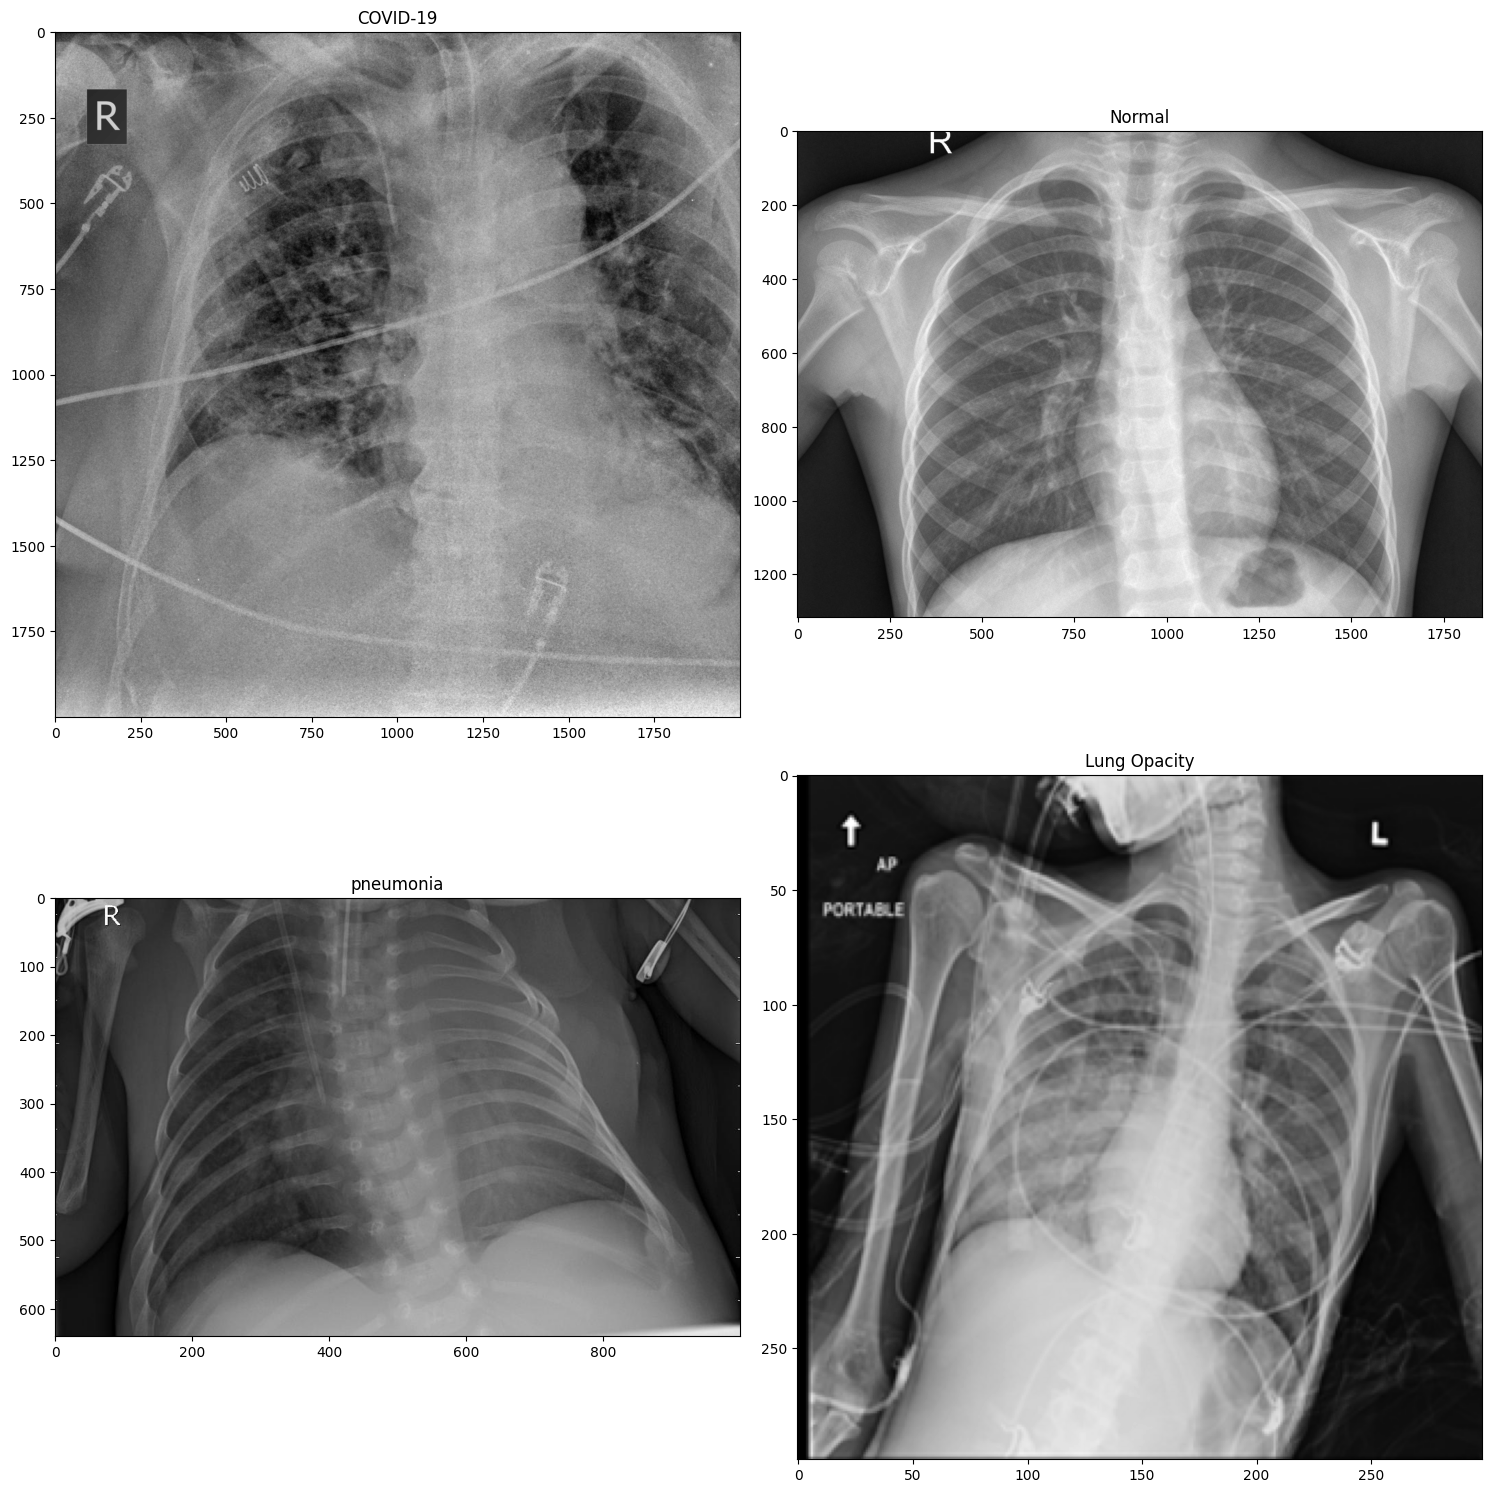

In [4]:
labels = ['COVID-19','Normal', 'pneumonia','Lung Opacity']
img1 = covid_train+"/COVID19(0).jpg"
img2 = normal_train+"/NORMAL(0).jpg"
img3 = pneumonia_train + "/PNEUMONIA(2690).jpg"
img4 = lung_opacity + "/Lung_Opacity-1981.png"

imgs = [img1, img2, img3,img4]

fig, ax = plt.subplots(2,2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

In [5]:
fpath = "/kaggle/input/new-dataset/new/data/Data/train"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:4]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories)) 

List of categories =  ['PNEUMONIA', 'NORMAL', 'COVID19', 'Lung_Opacity'] 

No. of categories =  4


In [6]:
import os
import cv2
from PIL import Image
import numpy as np

def load_images_and_labels(categories, batch_size=32):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        img_names = os.listdir(fpath+"/"+category)
        num_batches = len(img_names) // batch_size + int(len(img_names) % batch_size != 0)
        for i in range(num_batches):
            batch_names = img_names[i*batch_size:(i+1)*batch_size]
            batch_imgs = [cv2.imread(fpath+"/"+category+"/"+name) for name in batch_names]
            batch_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_imgs]
            batch_imgs = [np.array(Image.fromarray(img).resize((224, 224))) for img in batch_imgs]
            img_lst.extend(batch_imgs)
            labels.extend([index]*len(batch_imgs))
    return img_lst, labels


In [7]:
images, labels = load_images_and_labels(categories)
print("Number of images: ", len(images))
print("Number of labels: ", len(labels))

Number of images:  5638
Number of labels:  5638


In [8]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (5638, 224, 224, 3) 
Labels shape =  (5638,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))
#images = images.reshape((images.shape[0],1))

from keras.utils import to_categorical
label_output_matrix = to_categorical(labels, num_classes = 4, dtype ="int32")

x_train, x_test, y_train, y_test = train_test_split(images, label_output_matrix, test_size=0.2, random_state=24)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)


x_train shape =  (4510, 224, 224, 3)
y_train shape =  (4510, 4)

x_test shape =  (1128, 224, 224, 3)
y_test shape =  (1128, 4)


In [10]:
res_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    classes=4
)

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
#fully connected layer
model = tf.keras.models.Sequential()
model.add(res_model)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 127662212 (486.99 MB)
Trainable params: 12

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                            batch_size=32, epochs=10)

Epoch 1/10
141/141 [==============================] - 103s 366ms/step - loss: 1.8074 - accuracy: 0.7845 - val_loss: 0.6233 - val_accuracy: 0.7553
Epoch 2/10
141/141 [==============================] - 49s 346ms/step - loss: 0.2270 - accuracy: 0.9191 - val_loss: 0.9414 - val_accuracy: 0.7482
Epoch 3/10
141/141 [==============================] - 50s 354ms/step - loss: 0.1594 - accuracy: 0.9475 - val_loss: 0.6144 - val_accuracy: 0.7713
Epoch 4/10
141/141 [==============================] - 50s 351ms/step - loss: 0.1426 - accuracy: 0.9497 - val_loss: 0.7575 - val_accuracy: 0.8050
Epoch 5/10
141/141 [==============================] - 50s 353ms/step - loss: 0.1348 - accuracy: 0.9541 - val_loss: 0.9312 - val_accuracy: 0.7899
Epoch 6/10
141/141 [==============================] - 50s 352ms/step - loss: 0.1217 - accuracy: 0.9674 - val_loss: 11.7378 - val_accuracy: 0.4770
Epoch 7/10
141/141 [==============================] - 50s 352ms/step - loss: 0.1425 - accuracy: 0.9550 - val_loss: 11.6183 - val

In [14]:
mypredict = model.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)
evalute = model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(evalute[1] * 100))  
print("Loss: {}".format(evalute[0]))

36/36 [==============================] - 4s 93ms/step
[3 1 3 ... 3 3 3]
36/36 [==============================] - 3s 93ms/step - loss: 3.0660 - accuracy: 0.3626
Accuracy: 36.26%
Loss: 3.0659916400909424


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
x_output=model.predict(x_train)

141/141 [==============================] - 13s 93ms/step


In [17]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_output, y_train)
y_pred_rf = rf.predict(mypredict)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf)*100)
print("Random Forest Precision:", precision_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest Recall:", recall_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest F1-score:", f1_score(y_test, y_pred_rf,average='micro')*100)

rf_acc=accuracy_score(y_test, y_pred_rf)
rf_pre=precision_score(y_test, y_pred_rf,average='micro')
rf_rec=recall_score(y_test, y_pred_rf,average='micro')
rf_f1=f1_score(y_test, y_pred_rf,average='micro')

Random Forest Accuracy: 63.829787234042556
Random Forest Precision: 73.54443309499489
Random Forest Recall: 63.829787234042556
Random Forest F1-score: 68.343616516374


In [18]:
#Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(x_output, y_train)
y_pred_dt = dt.predict(mypredict)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt)*100)
print("Decision Tree Precision:", precision_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree Recall:", recall_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree F1-score:", f1_score(y_test, y_pred_dt,average='micro')*100)

dt_acc=accuracy_score(y_test, y_pred_dt)
dt_pre=precision_score(y_test, y_pred_dt,average='micro')
dt_rec=recall_score(y_test, y_pred_dt,average='micro')
dt_f1=f1_score(y_test, y_pred_dt,average='micro')

Decision Tree Accuracy: 63.20921985815603
Decision Tree Precision: 63.20921985815603
Decision Tree Recall: 63.20921985815603
Decision Tree F1-score: 63.20921985815603


In [19]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_output, y_train)
y_pred_knn = knn.predict(mypredict)

print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn)*100)
print("K-Nearest Neighbors Precision:", precision_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors Recall:", recall_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors F1-score:", f1_score(y_test, y_pred_knn, average='micro')*100)

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_pre = precision_score(y_test, y_pred_knn, average='micro')
knn_rec = recall_score(y_test, y_pred_knn, average='micro')
knn_f1 = f1_score(y_test, y_pred_knn, average='micro')


K-Nearest Neighbors Accuracy: 62.85460992907801
K-Nearest Neighbors Precision: 69.78346456692913
K-Nearest Neighbors Recall: 62.85460992907801
K-Nearest Neighbors F1-score: 66.13805970149255


In [20]:
# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(x_output, y_train)
y_pred_etc = etc.predict(mypredict)

print("Extra Trees Classifier Accuracy:", accuracy_score(y_test, y_pred_etc)*100)
print("Extra Trees Classifier Precision:", precision_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier Recall:", recall_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier F1-score:", f1_score(y_test, y_pred_etc, average='micro')*100)
                 
etc_acc = accuracy_score(y_test, y_pred_etc)
etc_pre = precision_score(y_test, y_pred_etc, average='micro')
etc_rec = recall_score(y_test, y_pred_etc, average='micro')
etc_f1 = f1_score(y_test, y_pred_etc, average='micro')


Extra Trees Classifier Accuracy: 62.4113475177305
Extra Trees Classifier Precision: 71.39959432048681
Extra Trees Classifier Recall: 62.4113475177305
Extra Trees Classifier F1-score: 66.60359508041628


In [21]:
from prettytable import PrettyTable

# Create a PrettyTable
table = PrettyTable()
table.field_names = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score']

# Add data to the table
table.add_row(['Random Forest', rf_acc, rf_pre, rf_rec, rf_f1])
table.add_row(['Extra Trees', etc_acc, etc_pre, etc_rec, etc_f1])
table.add_row(['K-Nearest Neighbors', knn_acc, knn_pre, knn_rec, knn_f1])
table.add_row(['Decision Tree', dt_acc, dt_pre, dt_rec, dt_f1])

# Print the table
print(table)

+---------------------+--------------------+--------------------+--------------------+--------------------+
|      Classifier     |      Accuracy      |     Precision      |       Recall       |      F1-score      |
+---------------------+--------------------+--------------------+--------------------+--------------------+
|    Random Forest    | 0.6382978723404256 | 0.7354443309499489 | 0.6382978723404256 |  0.68343616516374  |
|     Extra Trees     | 0.624113475177305  | 0.7139959432048681 | 0.624113475177305  | 0.6660359508041628 |
| K-Nearest Neighbors | 0.6285460992907801 | 0.6978346456692913 | 0.6285460992907801 | 0.6613805970149255 |
|    Decision Tree    | 0.6320921985815603 | 0.6320921985815603 | 0.6320921985815603 | 0.6320921985815603 |
+---------------------+--------------------+--------------------+--------------------+--------------------+
